In [12]:
from omegaconf import OmegaConf
from vitssm.models import build_model
from vitssm.data import get_dataset
import torch
from vitssm.utils.visual import model_output_to_video, display_video_frames_in_grid, save_videos_as_grid_gif
from einops import rearrange, repeat
from torchvision.io import write_video
import imageio
import matplotlib.pyplot as plt
import numpy as np

config = OmegaConf.load("configs/UPT/upt_3d_t_32_config.yml")
config.dataset.load_in_memory = False
config.dataset.mode = "test"
config.model.upt_autoencoder_checkpoint_path = "/home/david/projects/ViTSSM/checkpoints/ViTSSM/UPT/vmdsprites-UPT_VAE_T-32.pth"

model = build_model(config.model)
dataset = get_dataset(config.dataset)

app_checkpoint_path = "/home/david/projects/ViTSSM/checkpoints/ViTSSM/UPT/vmdsprites-UPT_3D_T-32.pth"
ckpt = torch.load(app_checkpoint_path)
app_ckpt = {key[13:]: val for key, val in ckpt["model"].items() if key.startswith("approximator")}

model.approximator.load_state_dict(app_ckpt)

/home/david/projects/ViTSSM/vitssm/models/upt/_next_frame.py:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(upt_autoencoder_checkpoint_path)
/tmp

<All keys matched successfully>

In [19]:
x = dataset[10]
x_fast = torch.cat([x[0], x[1]], dim=0)
x_fast = x_fast[::2, ...]
x = x[0].unsqueeze(0)
x_fast = x_fast.unsqueeze(0)
print(x.shape)

torch.Size([1, 4, 3, 32, 32])


# Rollout comparison

In [20]:
from vitssm.utils.visual import model_output_to_video, display_video_frames_in_grid
from einops import rearrange, repeat
from torchvision.io import write_video
import imageio
import numpy as np

bs, cl, ch, ht, wt = x.shape
spatial_scale = 1
temporal_scale = 1
n_steps = 64
device = torch.device("cuda")


model.eval()
model.to(device)

x_pred = rearrange(
    model_output_to_video(
        model.rollout_frames(x.to(device), n_steps=n_steps, temporal_scale=temporal_scale, spatial_scale=spatial_scale).squeeze(0).cpu(),
    ),
    "... c h w -> ... h w c",
)
x_pred_fast = rearrange(
    model_output_to_video(
        model.rollout_frames(x_fast.to(device), n_steps=n_steps, temporal_scale=temporal_scale, spatial_scale=spatial_scale).squeeze(0).cpu(),
    ),
    "... c h w -> ... h w c",
)

#print(x_pred.shape)
#display_video_frames_in_grid(x_pred)
#imageio.mimsave("x_pred_slow.gif", [np.array(x) for x in rearrange(model_output_to_video(x_pred), "... c h w -> ... h w c")])
save_videos_as_grid_gif([x_pred, x_pred_fast], (1, 2), "x_pred.gif")

Saved GIF to x_pred.gif


# Latent Space Similarity

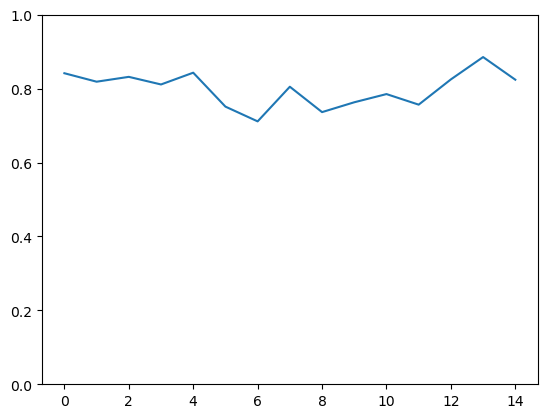

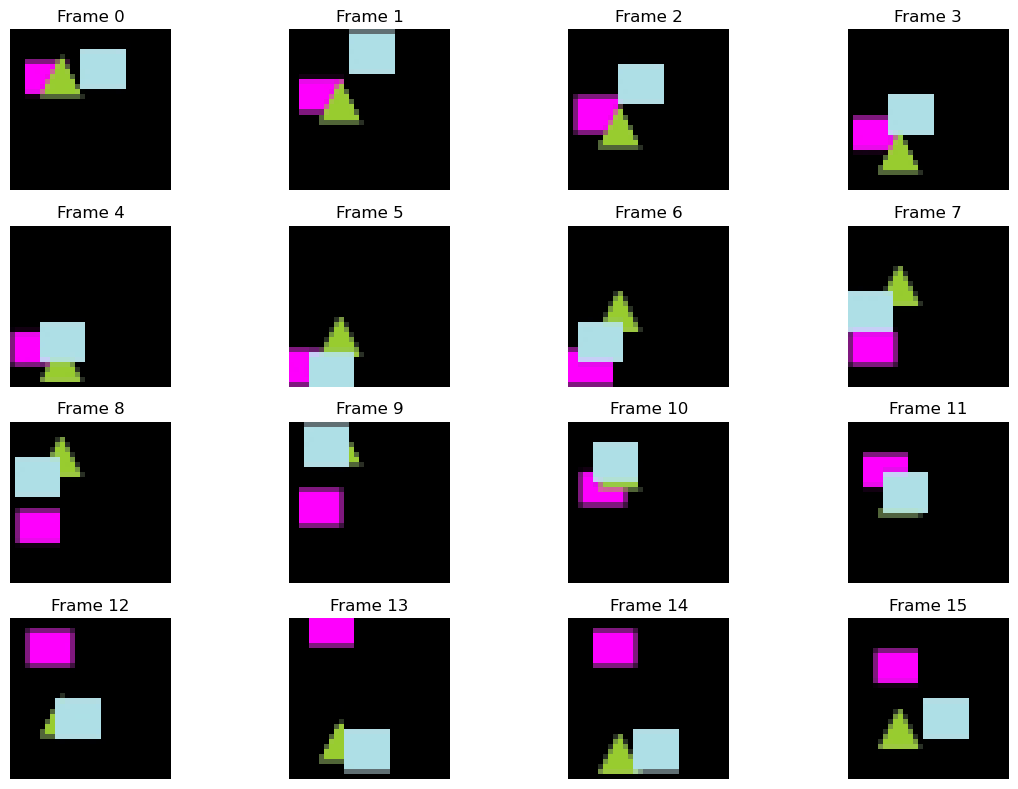

torch.Size([16, 4, 3, 32, 32])
Saved GIF to cos_sims.gif


In [69]:
from torch.nn.functional import cosine_similarity

config.dataset.num_frames = 64
config.dataset.context_length = 64
dataset = get_dataset(config.dataset)

x = dataset[90]
x = torch.split(x[0].unsqueeze(0), 4, dim=1)
x = torch.cat(x, dim=0)

z = model.autoencoder.encode(x.to(device))

cos_sims = [cosine_similarity(z[i], z[i+1], dim=-1).mean().cpu() for i in range(x.size(0) - 1)]

plt.plot(range(x.size(0) - 1), cos_sims, scaley=False)
display_video_frames_in_grid(x[:, 1])

cos_sims.append(torch.tensor(0.0))
print(x.shape)
x_weighted = x * torch.tensor(cos_sims).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)

x = model_output_to_video(rearrange(x, "b t c h w -> (b t) h w c"))
x_weighted = model_output_to_video(rearrange(x_weighted, "b t c h w -> (b t) h w c"))
save_videos_as_grid_gif([x, x_weighted], (1, 2), "cos_sims.gif")

TypeError: unsupported operand type(s) for *: 'numpy.ndarray' and 'Tensor'